In [19]:
import os
import sys
from sys import path
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
from scipy.optimize import least_squares
import json
import coord_helper as ch
import random
import h5py

STANDARDIZED INITIAL VARBS

In [20]:
config_file_name = 'config_mars_2024.json'
baseline_idx = 1

In [21]:
with open(f"{config_file_name}", "r") as f:
    config = json.load(f)
    dir_parents = []
    coords = []
    # unpack information from the json file
    # Call get_starting_index for all antennas except reference
    print("Antenna Details:")
    for i, (ant, details) in enumerate(config["antennas"].items()):
        if (i == 0) or (i ==baseline_idx):
            coords.append(details['coordinates'])
            dir_parents.append(details["path"])
    global_start_time = config["correlation"]["start_timestamp"]
    end_t = config["correlation"]["end_timestamp"]
    c_acclen = config["correlation"]["coarse_acclen"]
    v_acclen = config["correlation"]["vis_acclen"]
    visibility_window = config["correlation"]["visibility_window"]
    T_SPECTRA = config["correlation"]["point_PFB"] / config["correlation"]["sample_rate"]

print("Antenna Paths:", dir_parents)
print("Antenna Coordinates:", coords)
print("Visibility Accumulation Length", v_acclen)
print("Coarse Accumulation Length:", c_acclen)

Antenna Details:
Antenna Paths: ['/scratch/s/sievers/mohanagr/mars1_2024/baseband/', '/scratch/s/sievers/mohanagr/mars2_2024/baseband/']
Antenna Coordinates: [[79.41718333333333, -90.76735, 189], [79.41721666666666, -90.75885, 176]]
Visibility Accumulation Length 30000
Coarse Accumulation Length: 1000000


In [22]:
ref_coords = coords[0]
a2_coords = coords[1]

ref_path = dir_parents[0]
a2_path = dir_parents[1]

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

tle_path = outils.get_tle_file(global_start_time, "/project/s/sievers/mohanagr/OCOMM_TLES")

context = [global_start_time, visibility_window, [T_SPECTRA, v_acclen, v_nchunks], ref_coords, tle_path]

GET THE SAT PASSES LIST

In [24]:
with open("pulsedata_1721900002_1748541899.json", "r") as f:
    pulsedata = json.load(f)
    
    info = []
    for pulse_idx, details in enumerate(pulsedata["1721900002"]["antenna 1"]):
        #print(f"\n--------pulse idx {pulse_idx}---------")
        start_time = details["start"] * 5
        end_time = details["end"] * 5

        #timestream_offset = details["timestream_offset"]

        for satID, values in details["sats_present"].items():
            #
            # print(satID)
            for i in range(len(values)):
                pulse_info = []
                #print(values[i])
                chan = values[i][0]
                corr_offset = values[i][1]
                rel = values[i][2][0]

                pulse_info.append([start_time, end_time])
                pulse_info.append(int(satID))
                pulse_info.append(chan)
                pulse_info.append(corr_offset)

                info.append(pulse_info)
            
print(info)

[[[2110, 2630], 59051, 1836, 103156], [[2110, 2630], 59051, 1837, 103156], [[6920, 7230], 25338, 1841, 79705], [[8135, 8680], 59051, 1836, 79731], [[8135, 8680], 59051, 1837, 79731], [[12925, 13380], 25338, 1841, 79705], [[13600, 13905], 33591, 1849, 79730], [[13600, 13905], 33591, 1850, 79705], [[14150, 14695], 59051, 1836, 79731], [[14150, 14695], 59051, 1837, 79731], [[14870, 15215], 57166, 1836, 79731], [[14870, 15215], 57166, 1837, 79731], [[17330, 17605], 28654, 1836, 79705], [[17330, 17605], 28654, 1837, 79730]]


GET OVERALL OFFSET

In [6]:
with open("pulsedata_1721800002_1748962214.json", "r") as f:
    pulsedata = json.load(f)
    
    specnum_offsets = []
    for pulse_idx, details in enumerate(pulsedata["1721800002"]["antenna 1"]):

        timestream_offset = details["timestream_offset"]

        #here is where I want to impose my condition on what pulses I decide to use.
        #I'm thinking if RELIABLE then we take, and if it has multiple channels and both agree we take also.
        #question is how to distinguish between two satellites when they are in the same pulse. Ignore these?

        BOOL = False

CHECK WHICH PASS IS GOOD

In [25]:
#for initial timestamp 1721900002
idx_list = [2, 4, 5, 7, 9, 12]

#for initial timestamp 1721800002
#   first list
#idx_list = [0, 4, 5, 8, 9, 11, 14, 18, 19, 24, 25]


good_info = [info[i] for i in idx_list]
print(good_info)
for index in idx_list:
    print(info[index])

[[[6920, 7230], 25338, 1841, 79705], [[8135, 8680], 59051, 1837, 79731], [[12925, 13380], 25338, 1841, 79705], [[13600, 13905], 33591, 1850, 79705], [[14150, 14695], 59051, 1837, 79731], [[17330, 17605], 28654, 1836, 79705]]
[[6920, 7230], 25338, 1841, 79705]
[[8135, 8680], 59051, 1837, 79731]
[[12925, 13380], 25338, 1841, 79705]
[[13600, 13905], 33591, 1850, 79705]
[[14150, 14695], 59051, 1837, 79731]
[[17330, 17605], 28654, 1836, 79705]


In [63]:
pulse_idx = 30

#--------times-----
relative_start_time = info[pulse_idx][0][0]
pulse_duration_chunks = int(  (info[pulse_idx][0][1] - info[pulse_idx][0][0]) / (T_SPECTRA * v_acclen)  )
t_start = global_start_time + relative_start_time
t_end = t_start + visibility_window

#----get initialized information----
files_a1, idx1 = butils.get_init_info(t_start, t_end, ref_path)
files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)

#------get corrected offsets-----
idx_correction = info[pulse_idx][3] - 100000
if idx_correction>0:
    idx1_v = idx1 + idx_correction
    idx2_v = idx2
else:
    idx2_v = idx2 + np.abs(idx_correction)
    idx1_v = idx1
#print("Corrected Starting Indices:", idx1_v, idx2_v)

#-------set up channels-------
channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
chanstart = np.where(channels == 1834)[0][0] 
chanend = np.where(channels == 1852)[0][0]
nchans=chanend-chanstart

chan_bigidx = info[pulse_idx][2]
chanmap = channels[chanstart:chanend].astype(int)
chan_smallidx = np.where(chanmap == chan_bigidx)[0][0]

#--------open object----------
ant1 = bdc.BasebandFileIterator(files_a1, 0, idx1_v, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')
ant2 = bdc.BasebandFileIterator(files_a2, 0, idx2_v, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')

#--------get visibilities-----
m1=ant1.spec_num_start
m2=ant2.spec_num_start

visibility_phased = np.zeros((v_nchunks,len(ant1.channel_idxs)), dtype='complex64')
time_pulse=time.time()
#print(f"--------- Processing Pulse Idx {pulse_idx} ---------")
for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):
        xcorr = ch.avg_xcorr_4bit_2ant_float(
            chunk1['pol0'], 
            chunk2['pol0'],
            chunk1['specnums'],
            chunk2['specnums'],
            m1+i*v_acclen,
            m2+i*v_acclen)
        visibility_phased[i,:] = np.sum(xcorr,axis=0)/v_acclen
        #print("CHUNK", i, " has ", xcorr.shape[0], " rows")
print(f"DONE PULSE {pulse_idx}. TIME:", time.time()-time_pulse)
visibility_phased = np.ma.masked_invalid(visibility_phased)
vis_phase = np.angle(visibility_phased)
obs = np.unwrap(vis_phase[0:pulse_duration_chunks, chan_smallidx])

Not reading any data
ACCLEN RECEIVED IS 30000
took 0.243 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721831648.raw
START SPECNUM IS 2923671373 obj start at 2921291002
ACCLEN RECEIVED IS 30000
took 1.842 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721831665.raw
START SPECNUM IS 2979915032 obj start at 2978521217
took 1.828 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721831693.raw
took 1.839 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721831709.raw
took 1.755 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721831737.raw
took 1.777 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17218/1721831753.raw
took 1.873 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17218/1721831781.raw
took 1.840 seconds to read raw data on  /scratch/s/sievers/moh

catalog #28654 epoch 2024-07-24 20:56:55 UTC


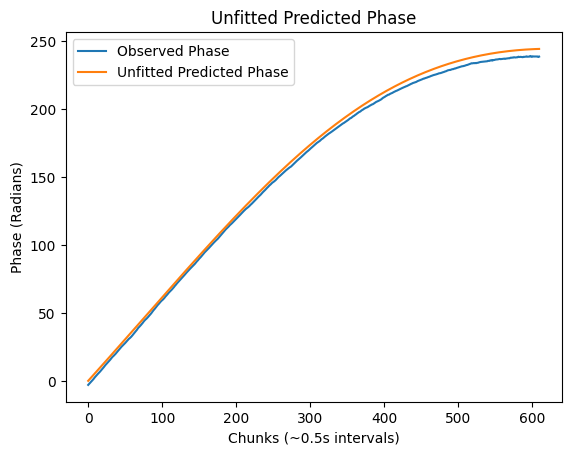

In [64]:
plt.plot(obs, label="Observed Phase")
plt.plot(ch.phase_pred(a2_coords, pulse_idx, info, context), label="Unfitted Predicted Phase")
plt.xlabel("Chunks (~0.5s intervals)")
plt.ylabel("Phase (Radians)")
plt.title("Unfitted Predicted Phase")
plt.legend()

GET DATA OVERALL

In [26]:
observed_data = []
time_total = time.time()
for pulse_idx in range(len(good_info)):

    print(f"---------STARTING PULSE {pulse_idx}---------")

    #--------times-----
    relative_start_time = good_info[pulse_idx][0][0]
    pulse_duration_chunks = int((good_info[pulse_idx][0][1] - good_info[pulse_idx][0][0]) / (T_SPECTRA * v_acclen)  )
    t_start = global_start_time + relative_start_time
    t_end = t_start + visibility_window

    #----get initialized information----
    files_a1, idx1 = butils.get_init_info(t_start, t_end, ref_path)
    files_a2, idx2 = butils.get_init_info(t_start, t_end, a2_path)

    #------get corrected offsets-----
    idx_correction = good_info[pulse_idx][3] - 100000
    if idx_correction>0:
        idx1_v = idx1 + idx_correction
        idx2_v = idx2
    else:
        idx2_v = idx2 + np.abs(idx_correction)
        idx1_v = idx1
    #print("Corrected Starting Indices:", idx1_v, idx2_v)

    #-------set up channels-------
    channels = bdc.get_header(files_a1[0])["channels"].astype('int64')
    chanstart = np.where(channels == 1834)[0][0] 
    chanend = np.where(channels == 1852)[0][0]
    nchans=chanend-chanstart

    chan_bigidx = good_info[pulse_idx][2]
    chanmap = channels[chanstart:chanend].astype(int)
    chan_smallidx = np.where(chanmap == chan_bigidx)[0][0]

    #--------open object----------
    ant1 = bdc.BasebandFileIterator(files_a1, 0, idx1_v, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')
    ant2 = bdc.BasebandFileIterator(files_a2, 0, idx2_v, v_acclen, nchunks= v_nchunks, chanstart = chanstart, chanend = chanend, type='float')

    #--------get visibilities-----
    m1=ant1.spec_num_start
    m2=ant2.spec_num_start

    visibility_phased = np.zeros((v_nchunks,len(ant1.channel_idxs)), dtype='complex64')
    time_pulse=time.time()
    #print(f"--------- Processing Pulse Idx {pulse_idx} ---------")
    for i, (chunk1,chunk2) in enumerate(zip(ant1,ant2)):
            xcorr = ch.avg_xcorr_4bit_2ant_float(
                chunk1['pol0'], 
                chunk2['pol0'],
                chunk1['specnums'],
                chunk2['specnums'],
                m1+i*v_acclen,
                m2+i*v_acclen)
            visibility_phased[i,:] = np.sum(xcorr,axis=0)/v_acclen
            #print("CHUNK", i, " has ", xcorr.shape[0], " rows")
    print(f"DONE PULSE {pulse_idx}. TIME:", time.time()-time_pulse)
    visibility_phased = np.ma.masked_invalid(visibility_phased)
    vis_phase = np.angle(visibility_phased)
    obs = np.unwrap(vis_phase[0:pulse_duration_chunks, chan_smallidx])
    observed_data.append(obs)

print("Done with everything. Time taken:", time.time() - time_total)

---------STARTING PULSE 0---------
Not reading any data
ACCLEN RECEIVED IS 30000
took 0.228 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17219/1721906912.raw
START SPECNUM IS 4268361798 obj start at 4267751446
ACCLEN RECEIVED IS 30000
took 1.812 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17219/1721906905.raw
START SPECNUM IS 4274586600 obj start at 4273528707
took 1.819 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17219/1721906949.raw
took 1.825 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17219/1721906956.raw
took 1.882 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17219/1721906994.raw
took 1.815 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars1_2024/baseband/17219/1721907001.raw
took 1.733 seconds to read raw data on  /scratch/s/sievers/mohanagr/mars2_2024/baseband/17219/1721907038.raw
took 1.848 seconds to read 

KeyboardInterrupt: 

In [69]:
import h5py

#convention is that main group name is the start of the total thing, i.e. global start time
#and then the name of the visibility is for each pulse, the start time of the pulse (wrt global start time) with the channel after.

visibilities = observed_data[0]
with h5py.File('visibilities.h5', 'w') as f:
    timestamp = f.create_group(f'/{global_start_time}')

    
    for pulse_idx, observed in enumerate(observed_data):
        satID = good_info[pulse_idx][1]
        offset = good_info[pulse_idx][3]
        chan = good_info[pulse_idx][2]
        start_time = good_info[pulse_idx][0][0]
        end_time = good_info[pulse_idx][0][1]
        
        pulse_array = timestamp.create_dataset(f'{start_time}_{chan}', data=observed)
        pulse_array.attrs['pulse_info'] = [start_time, end_time, satID, chan, offset]


In [18]:
observed_data = []
info = []

with h5py.File('visibilities.h5', 'r') as f:
    for pulse in f[f'/{global_start_time}']:
        # Access a dataset
        print(pulse)
        p = f[f'/{global_start_time}/{pulse}'].attrs['pulse_info']
        pulse_info = [[int(p[0]), int(p[1])], int(p[2]), int(p[3]), int(p[4])]
        info.append(pulse_info)
        data = f[f'/{global_start_time}/{pulse}'][:]
        observed_data.append(data)
print(info)

#possible to-do here is to order them by start time. but might not really matter.

10975_1837
17005_1836
22070_1841
23025_1837
27945_1850
28075_1841
28075_1850
28275_1841
4950_1837
7000_1836
715_1836
[[[10975, 11440], 59051, 1837, 86568], [[17005, 17530], 59051, 1836, 86568], [[22070, 22425], 25338, 1841, 86568], [[23025, 23570], 59051, 1837, 48959], [[27945, 28075], 33591, 1850, 109994], [[28075, 28275], 25338, 1841, 109993], [[28075, 28275], 33591, 1850, 109993], [[28275, 28555], 25338, 1841, 86569], [[4950, 5270], 59051, 1837, 109993], [[7000, 7145], 28654, 1836, 109993], [[715, 1110], 28654, 1836, 86568]]


PLOT PRE-FIT

0


IndexError: invalid index to scalar variable.

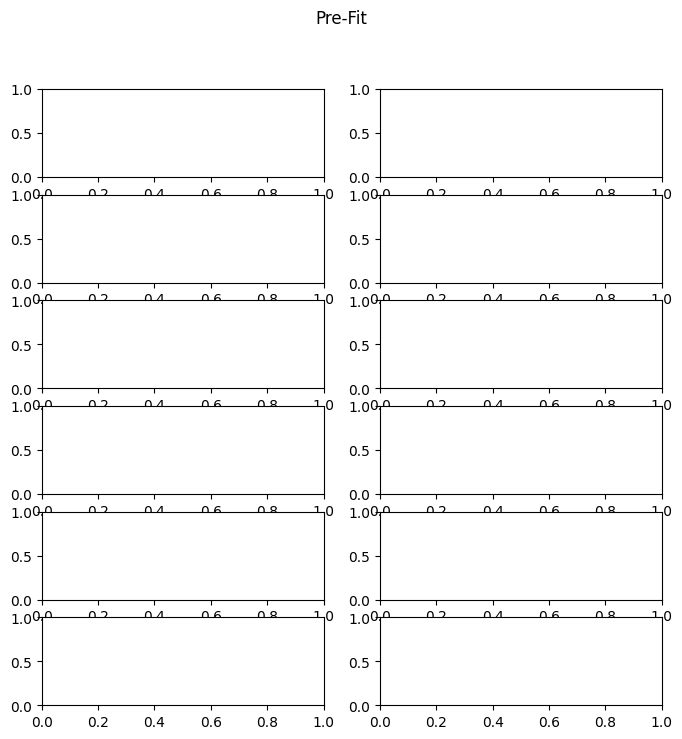

In [13]:
fig, ax = plt.subplots(int(np.ceil(len(observed_data)/2)), 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Pre-Fit")
for pulse_idx in range(len(observed_data)):
    print(pulse_idx)
    predicted_data = ch.phase_pred(a2_coords, pulse_idx, info, context)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(observed_data[pulse_idx])
    ax[pulse_idx].plot(predicted_data)
plt.tight_layout()
#fig.savefig(path.join(out_path,f"pre_fit_calib_plots_{tstart}.jpg"))
#print(path.join(out_path,f"dg_cxcorr_{tstart}_{pstart}_{pend}.jpg"))

In [16]:
fit_trf_og = ch.fitting_all(observed_data, [79.41721666666666, -90.75885, 183], ch.phase_pred, good_info, context)[0]

catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #28654 epoch 2024-07-24 20:56:55 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #59051 epoch 2024-07-24 21:55:34 UTC
catalog #25338 epoch 2024-07-24 21:35:17 UTC
catalog #5

In [17]:
print(fit_trf_og)

[ 79.41722339 -90.75880618 183.43734783]


In [18]:
ch.distance_calculator(a2_coords, fit_trf_og)

(1.165280599078356, 7.4373478289018635)

In [26]:
fuzzed_coords = ch.make_fuzzed_coords(a2_coords)
for cord in fuzzed_coords:
    print(cord)

[[79.41718332787713, -90.75872831881038, 168.80057472722063], [79.4171536958661, -90.75857986851922, 176.38138814155312], [79.41726591259784, -90.7585700867322, 185.52394276017986], [79.41716325877955, -90.75925337634278, 180.93512787553277], [79.41721069920285, -90.75900742735772, 179.35106837203253]]


In [29]:
fitted_trf = []
#fitted_trf.append(fitted_trf_og)

for coords in fuzzed_coords:
    print(coords)
    single_fit = ch.fitting_all(observed_data, coords, ch.phase_pred, good_info, context, method='trf')[0]
    fitted_trf.append(single_fit)

print(fitted_trf)

[79.41718332787713, -90.75872831881038, 168.80057472722063]
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12

In [30]:
for cord in fitted_trf:
    print(cord)

[array([ 79.41724391, -90.75895515, 183.52417244]), array([ 79.41724391, -90.75895515, 183.52465278]), array([ 79.41724391, -90.75895515, 183.52433558]), array([ 79.41724391, -90.75895515, 183.52453272]), array([ 79.41724391, -90.75895515, 183.52455662])]


In [43]:
fit_trf_og = ch.fitting_all(observed_data, a2_coords, phase_pred, good_info)[0]
fit_lm_og = ch.fitting_all(observed_data, a2_coords, phase_pred, good_info, method = 'lm')[0]

catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #5

In [ ]:
fitted_trf.append(fit_trf_og)
fitted_lm.append(fit_lm_og)

In [58]:
print(a2_coords)
print(fitted_coords_trf)
print(fitted_coords_lm)

[79.41721666666666, -90.75885, 176]
[ 79.41724391 -90.75895515 183.52471169]
[ 79.41724391 -90.75895515 183.52455638]


AttributeError: 'list' object has no attribute 'type'

In [13]:
print(a2_coords)
fit_1_consensus = [79.4172439, -90.75895515, 183.524]
print(fit_1_consensus)
fit_2_consensus = [ 79.41722474, -90.75872107, 183.38773103]
print(fit_2_consensus)

[79.41721666666666, -90.75885, 176]
[79.4172439, -90.75895515, 183.524]
[79.41722474, -90.75872107, 183.38773103]


In [20]:
ch.distance_calculator(fit_2_consensus, fit_trf_og)

(1.7433818201041595, 0.04961679890186588)

In [ ]:
ch.distance_calculator(fit_1_consensus, a2_coords)

In [57]:
ch.distance_calculator(a2_coords, fitted_coords_trf)

(3.7107812397936204, 7.524711689204253)

In [ ]:
fig, ax = plt.subplots(int(np.ceil(len(observed_data)/2)), 2)
fig.set_size_inches(8, 8)
ax = ax.flatten()
fig.suptitle(f"Post-Fit")
for pulse_idx in range(len(observed_data)):
    print(pulse_idx)
    predicted_data = phase_pred(a2_coords, info, pulse_idx)
    ax[pulse_idx].set_title(f"Pulse Idx {pulse_idx}")
    ax[pulse_idx].plot(observed_data[pulse_idx])
    ax[pulse_idx].plot(predicted_data)
plt.tight_layout()
#fig.savefig(path.join(out_path,f"pre_fit_calib_plots_{tstart}.jpg"))
#print(path.join(out_path,f"dg_cxcorr_{tstart}_{pstart}_{pend}.jpg"))

catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC


Text(0.5, 1.0, 'Post-Fit')

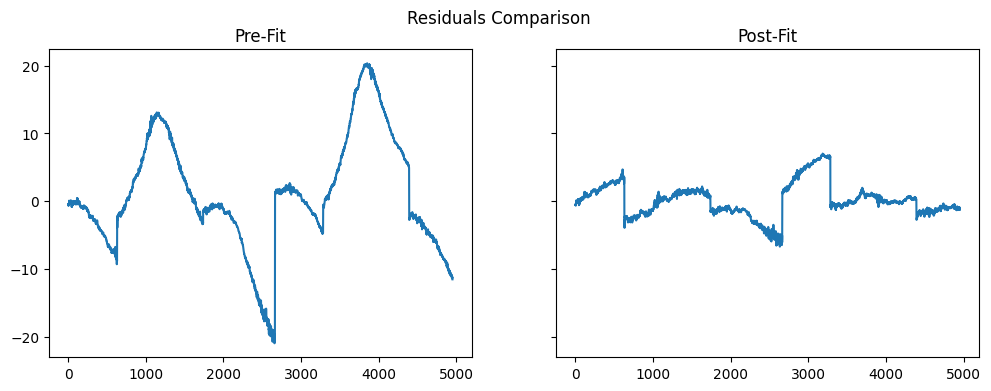

In [45]:
fig, ax = plt.subplots(1,2, sharey=True)
fig.set_size_inches(12, 4)
ax = ax.flatten()
fig.suptitle("Residuals Comparison")  #add start time into title!!
ax[0].plot(ch.residuals_all(a2_coords, observed_data, phase_pred, info))
ax[0].set_title("Pre-Fit")
ax[1].plot(ch.residuals_all(fitted_coords_trf, observed_data, phase_pred, info))
ax[1].set_title("Post-Fit")


catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC


Text(0.5, 1.0, 'LM')

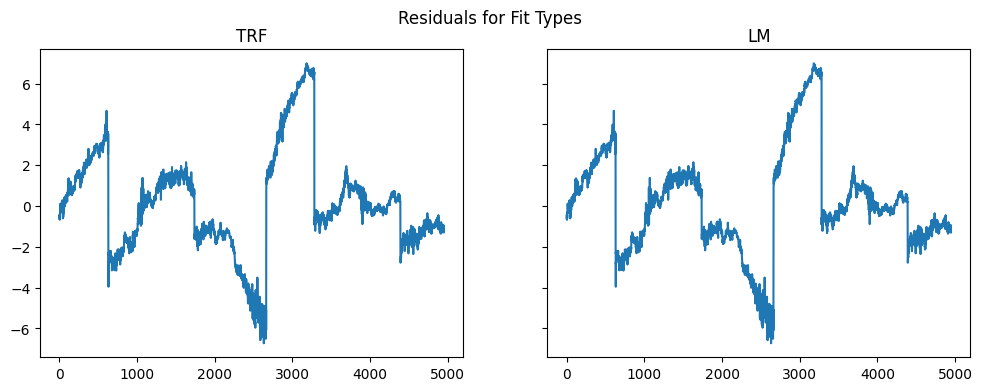

In [46]:
fig, ax = plt.subplots(1,2, sharey=True)
fig.set_size_inches(12, 4)
ax = ax.flatten()
fig.suptitle("Residuals for Fit Types")  #add start time into title!!
ax[0].plot(ch.residuals_all(fitted_coords_trf, observed_data, phase_pred, info))
ax[0].set_title("TRF")
ax[1].plot(ch.residuals_all(fitted_coords_lm, observed_data, phase_pred, info))
ax[1].set_title("LM")


catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC


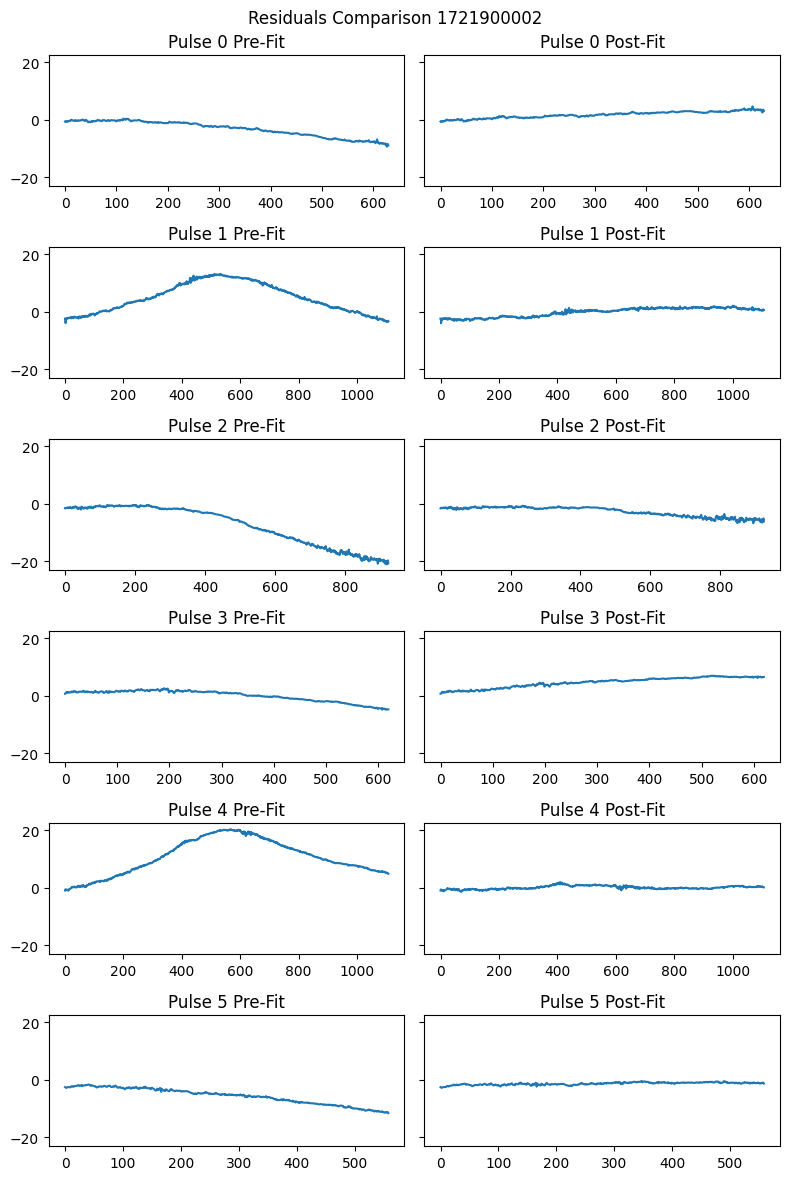

In [48]:
fig, ax = plt.subplots(len(observed_data),2, sharey=True)
fig.set_size_inches(8, 12)
ax = ax.flatten()
fig.suptitle(f"Residuals Comparison {global_start_time}")
for i in range(len(observed_data)):  

    ax[2*i].plot(ch.residuals_individual(a2_coords, observed_data, phase_pred, info, i))
    ax[2*i].set_title(f"Pulse {i} Pre-Fit")

    ax[2*i +1].plot(ch.residuals_individual(fitted_coords_trf, observed_data, phase_pred, info, i))
    ax[2*i +1].set_title(f"Pulse {i} Post-Fit")

fig.tight_layout()

#fig.savefig(path.join(out_path,f"residuals_coordfit_{global_start_time}.jpg"))
#print("saved residual plot to:", path.join(out_path,f"residuals_coordfit_{global_start_time}.jpg"))


catalog #28654 epoch 2024-07-25 20:44:12 UTC


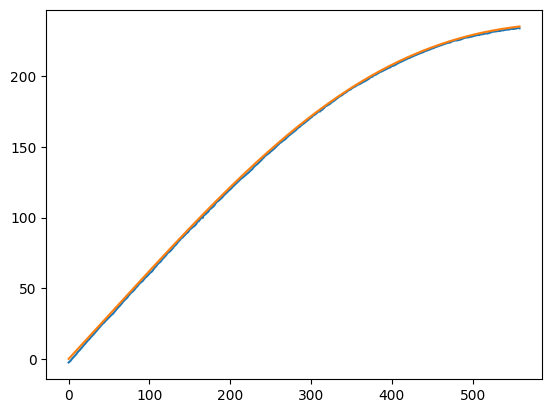

In [50]:
idx = 5

plt.plot(observed_data[idx])

#plt.plot(phase_pred(a2_coords, info, idx))
plt.plot(phase_pred(fitted_coords_trf, info, idx))

In [24]:
import stats_helper as ch

import importlib
importlib.reload(ch)


ModuleNotFoundError: No module named 'stats_helper'

In [23]:
coords_idx5 = ch.fitting_individual(observed_data[5], a2_coords, phase_pred, info, 5)[0]

NameError: name 'phase_pred' is not defined

In [64]:
print(a2_coords)
print(fitted_coords_trf)
print(coords_idx5)
print(len(observed_data))

[79.41721666666666, -90.75885, 176]
[ 79.41722658 -90.75901238 183.92610356]
[ 79.41718199 -90.76804287 205.25924637]
7


catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #25338 epoch 2024-07-25 21:09:12 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #33591 epoch 2024-07-25 21:24:09 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #59051 epoch 2024-07-25 21:33:51 UTC
catalog #57166 epoch 2024-07-25 21:41:50 UTC
catalog #57166 epoch 2024-07-25 21:41:50 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC
catalog #28654 epoch 2024-07-25 20:44:12 UTC


IndexError: list index out of range

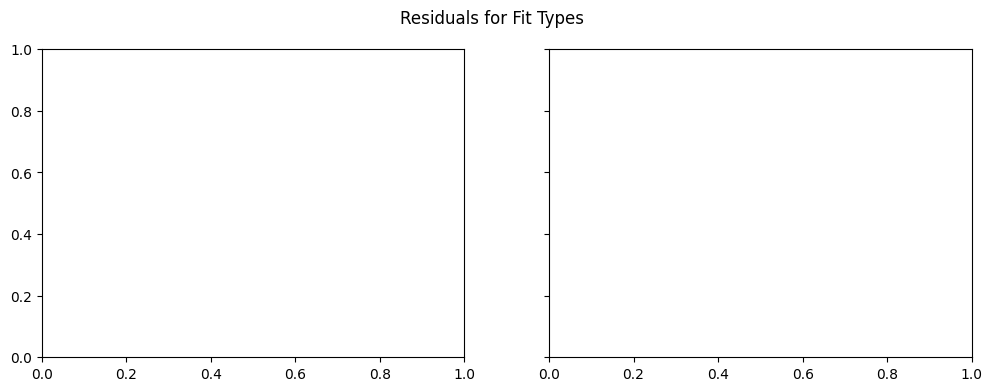

In [61]:
fig, ax = plt.subplots(1,2, sharey=True)
fig.set_size_inches(12, 4)
ax = ax.flatten()
fig.suptitle("Residuals for Fit Types")  #add start time into title!!
ax[0].plot(residuals_all(fitted_coords_trf, observed_data[5], phase_pred, info))
ax[0].set_title("TRF")
ax[1].plot(residuals_all(coords_idx5, observed_data[5], phase_pred, info))
ax[1].set_title("LM")

catalog #25338 epoch 2024-07-25 21:09:12 UTC


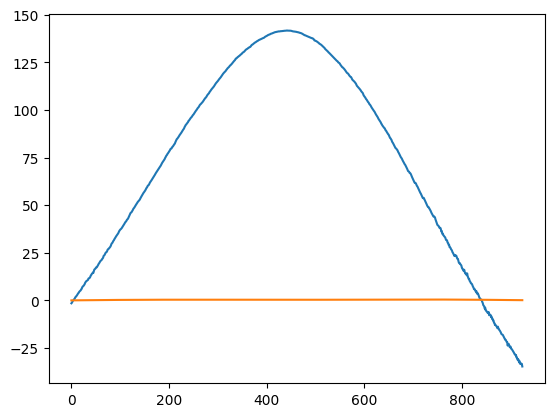

In [43]:
plt.plot(observed_data[5])
#plt.plot(phase_pred(fitted_coords_trf, info, 5))
plt.plot(phase_pred(coords_idx5, info, 5))
